# RNN Classifying Names
exercise from https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb

In [2]:
import glob

all_filenames = glob.glob('data/names/*.txt')
print(all_filenames)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
print(all_letters)
n_letters = len(all_letters)
print(n_letters)

def unicode_to_ascii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57
Slusarski


In [4]:
# Build the category_lines dict, a list of names per lang
category_lines = {}
all_categories = []

# read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

lines = readLines(all_filenames[0])
print(lines)

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar', 'Nader', 'Gaber', 'Abboud', 'Maalouf', 'Zogby', 'Srour', 'Bahar', 'Mustafa', 'Hanania', 'Daher', 'Tuma', 'Nahas', 'Saliba', 'Shamoon', 'Handal', 'Baba', 'Amari', 'Bahar', 'Atiyeh', 'Said', 'Khouri', 'Tahan', 'Baba', 'Mustafa', 'Guirguis', 'Sleiman', 'Seif', 'Dagher', 'Bahar', 'Gaber', 'Harb', 'Seif', 'Asker', 'Nader', 'Antar', 'Awad', 'Srour', 'Shadid', 'Hajjar', 'Hanania', 'Kalb', 'Shadid', 'Bazzi', 'Mustafa', 'Masih', 'Ghanem', 'Haddad', 'Isa', 'Antoun', 'Sarraf', 'Sleiman', 'Dagher', 'Najjar', 'Malouf', 'Nahas', 'Naser', 'Saliba', 'Shamon', 'Malouf', 'Kalb', 'Daher', 'Maalouf', 'Wasem', 'Kanaan', 'Naifeh', 'Boutros', 'Moghadam', 'Masih', 'Sleiman', 'Aswad', 'Cham', 'Assaf', 'Quraishi', 'Shalhoub', 'Sabbag', 'Mifsud', 'Gaber', 'Shammas', 'Tannous', 'Sleiman', 'Bazzi', 'Quraishi', 'Rahal', 'Ch

In [5]:
for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


In [6]:
print(category_lines['Chinese'][:10])

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']


# Turning Names into Tensors

To represent a single letter, we use a "one-hot vector" of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [7]:
import torch

# Demonstrate only
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter) # .find() give the index
    tensor[0][letter_index] = 1
    return tensor

print(letter_to_tensor('D'))



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     1     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]



In [8]:
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

# print(line_to_tensor('Hello'))
print(line_to_tensor('Joneson').size())


torch.Size([7, 1, 57])


In [9]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)  #  this 1 is the dimension over for the cat function
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [10]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


In [12]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.9054 -2.8342 -2.8403 -2.8987 -2.8808 -2.9086 -2.9031 -2.9370 -2.8213 -2.9213

Columns 10 to 17 
-3.0196 -2.8855 -2.8082 -2.8135 -2.8715 -2.9366 -2.8912 -2.9766
[torch.FloatTensor of size 1x18]



# Preparing for Training

In [13]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)  # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Polish', 12)


In [14]:
import random

def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Czech / line = Pachr
category = Dutch / line = Arendonk
category = Vietnamese / line = Than
category = Arabic / line = Gerges
category = Portuguese / line = Henriques
category = English / line = Raine
category = Irish / line = Simon
category = Scottish / line = Hill
category = English / line = Wooldridge
category = Irish / line = Reilly


# Training the Network
Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [15]:
criterion = nn.NLLLoss()

In [16]:
learning_rate = 5e-3
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

Each loop of training will:
- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
 - Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [17]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):  # tensor.size, 1st dimension
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    optimizer.step()
    
    return output, loss.data[0]

In [18]:
import time
import math

n_epoches = 100000
print_every = 3000
plot_every = 1000

# track loss
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [19]:
start = time.time()

for epoch in range(1, n_epoches + 1):
    # get a random training data and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # print epoch # and else
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch/n_epoches * 100, time_since(start), loss if epoch == 1000 else all_losses[-1], line, guess, correct))
    
    # add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

3000 3% (0m 3s) 2.8183 Eliovitch / Irish ✗ (Russian)
6000 6% (0m 8s) 2.6021 Mozdzierz / Greek ✗ (Polish)
9000 9% (0m 12s) 2.2909 Vinh / Vietnamese ✓
12000 12% (0m 16s) 2.1006 Close / Japanese ✗ (Greek)
15000 15% (0m 21s) 2.0263 Bui / Chinese ✗ (Vietnamese)
18000 18% (0m 25s) 1.9609 Bohunovsky / Polish ✗ (Czech)
21000 21% (0m 28s) 1.9165 Iseki / Polish ✗ (Japanese)
24000 24% (0m 32s) 1.7525 Gouveia / Spanish ✗ (Portuguese)
27000 27% (0m 36s) 1.7169 Rosenberg / Dutch ✗ (German)
30000 30% (0m 39s) 1.6626 Chau / Vietnamese ✓
33000 33% (0m 43s) 1.6483 Dam / Vietnamese ✓
36000 36% (0m 47s) 1.7336 Karameros / Greek ✓
39000 39% (0m 52s) 1.5711 Ta / Vietnamese ✓
42000 42% (0m 56s) 1.5359 Beyer / German ✓
45000 45% (1m 1s) 1.4759 Galenkovsky / Polish ✗ (Russian)
48000 48% (1m 5s) 1.4889 Koury / Arabic ✓
51000 51% (1m 10s) 1.4536 Verney / English ✓
54000 54% (1m 15s) 1.4866 Jian / Chinese ✓
57000 56% (1m 19s) 1.4618 Paulis / Greek ✗ (Dutch)
60000 60% (1m 23s) 1.3740 Rim / Korean ✓
63000 63% (1m 2

# plot the result

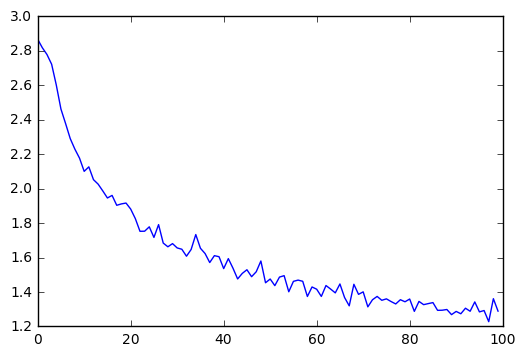

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

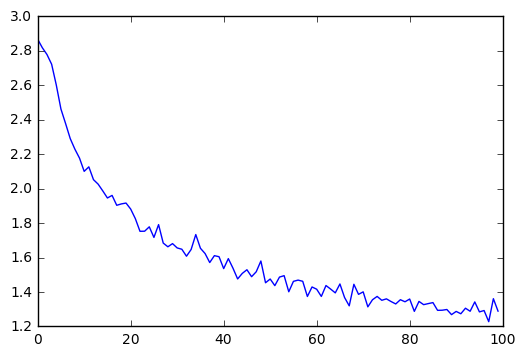

In [21]:
plt.figure()
plt.plot(all_losses)

# Evaluation

see the result but don't train the network anymore

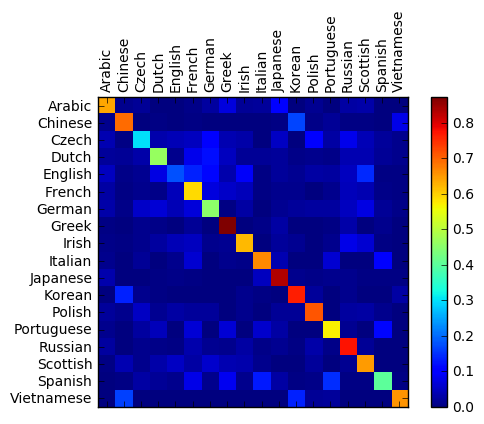

In [22]:
# record the correct guesses in a confusion matrix

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# make a function to return the output only
def evaluate(line_tensor):
    hidden =rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# go through a bunch of examples and record the correct predicton
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Setup plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# setup axis
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## Using the model to predict

In [23]:
def predict(input_line, n_predictions=3):
    print('\nYour input name is "%s"' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))
    
    top_v, top_i = output.data.topk(n_predictions, 1, True)
    predictions = []
    
    for i in range(n_predictions):
        value = top_v[0][i]
        category_index = top_i[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))

In [24]:
predict('Satoshi')


Your input name is "Satoshi"
(-0.49) Japanese
(-2.37) Italian
(-2.46) Arabic
